# Named Entity Recognition (NER)

## Loading essential packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Data Pre-processing

In [2]:
with open("ner.txt","r") as f:
  raw_corpus = f.readlines()

raw_corpus[0]

'EU NNP I-NP I-ORG\n'

In [3]:
corpus = []

for i in raw_corpus:
  corpus.append(i[:-1])

corpus[0]

'EU NNP I-NP I-ORG'

In [4]:
# x contains words and y contains pos-tags
sample = []
temp = []
words = []
tags = []

# converting words into sentence
for i in corpus:
  if (i):
    s = i.split()
    if s[0] != '.' and len(s)==4:
        t = (s[0], s[-1])
        temp.append(t)
        words.append(s[0])
        tags.append(s[-1])
    else:
        sample.append(temp)
        temp = []
        
sample[0]

[('EU', 'I-ORG'),
 ('rejects', 'O'),
 ('German', 'I-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'I-MISC'),
 ('lamb', 'O')]

In [5]:
# calculating max length of words in longest sentence

max_len = 0

for i in sample:
  if len(i) > max_len:
    max_len = len(i)

max_len

1231

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

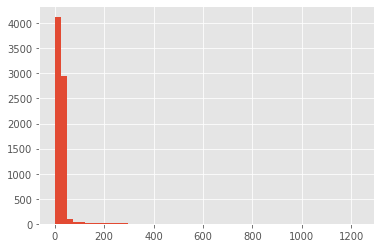

In [7]:
plt.hist([len(s) for s in sample], bins=50)
plt.show()

In [8]:
words=list(set(words))
words.append("ENDPAD")
len_words=len(words)

In [9]:
tags=list(set(tags))
tags.append("ENDPAD")
len_tags=len(tags)

In [10]:
print(len_words, len_tags)

23624 9


In [11]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
word2idx['a']

1768

In [13]:
tag2idx['O']

3

## Padding the Sentences and Tags

In [14]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sample]
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=len_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sample]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [15]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=len_tags) for i in y]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
# converting into numpy arrays

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## RNN Model

In [18]:
rnn_input = Input(shape=(140,))
rnn_model = Embedding(input_dim=len_words, output_dim=140, input_length=140)(rnn_input)
rnn_model = Dropout(0.1)(rnn_model)
rnn_model = SimpleRNN(units=100, return_sequences=True, recurrent_dropout=0.1)(rnn_model)
rnn_out = TimeDistributed(Dense(len_tags, activation="softmax"))(rnn_model)

In [19]:
rnn_model = Model(rnn_input, rnn_out)
rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 140, 140)          3307360   
_________________________________________________________________
dropout (Dropout)            (None, 140, 140)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 140, 100)          24100     
_________________________________________________________________
time_distributed (TimeDistri (None, 140, 9)            909       
Total params: 3,332,369
Trainable params: 3,332,369
Non-trainable params: 0
_________________________________________________________________


In [20]:
rnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [21]:
rnn_training = rnn_model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
148/148 [==============================] - 11s 67ms/step - loss: 0.3928 - acc: 0.9208 - val_loss: 0.1157 - val_acc: 0.9713
Epoch 2/5
148/148 [==============================] - 12s 80ms/step - loss: 0.0958 - acc: 0.9730 - val_loss: 0.0586 - val_acc: 0.9818
Epoch 3/5
148/148 [==============================] - 12s 81ms/step - loss: 0.0465 - acc: 0.9866 - val_loss: 0.0386 - val_acc: 0.9900
Epoch 4/5
148/148 [==============================] - 10s 69ms/step - loss: 0.0237 - acc: 0.9952 - val_loss: 0.0292 - val_acc: 0.9919
Epoch 5/5
148/148 [==============================] - 10s 67ms/step - loss: 0.0130 - acc: 0.9973 - val_loss: 0.0257 - val_acc: 0.9927


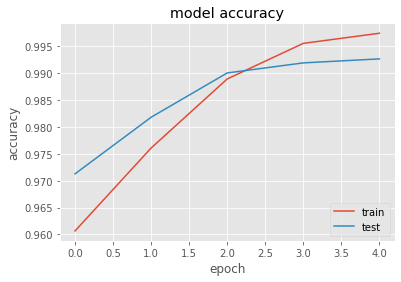

In [22]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [23]:
rnn_model.save("rnn_model")

INFO:tensorflow:Assets written to: rnn_model/assets


In [24]:
loss, accuracy = rnn_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

47/47 [==============================] - 0s 8ms/step - loss: 0.0274 - acc: 0.9921
Loss: 0.027430135756731033,
Accuracy: 0.9921307563781738


## Bi-LSTM Model

In [25]:
lstm_input = Input(shape=(140,))
lstm_model = Embedding(input_dim=len_words, output_dim=140, input_length=140)(lstm_input)
lstm_model = Dropout(0.1)(lstm_model)
lstm_model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(lstm_model)
lstm_out = TimeDistributed(Dense(len_tags, activation="softmax"))(lstm_model)

In [26]:
lstm_model = Model(lstm_input, lstm_out)
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 140)          3307360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 140)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 200)          192800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 9)            1809      
Total params: 3,501,969
Trainable params: 3,501,969
Non-trainable params: 0
_________________________________________________________________


In [27]:
lstm_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
lstm_training = lstm_model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
148/148 [==============================] - 38s 241ms/step - loss: 0.5390 - accuracy: 0.9350 - val_loss: 0.1022 - val_accuracy: 0.9709
Epoch 2/5
148/148 [==============================] - 34s 227ms/step - loss: 0.0878 - accuracy: 0.9720 - val_loss: 0.0595 - val_accuracy: 0.9775
Epoch 3/5
148/148 [==============================] - 34s 228ms/step - loss: 0.0489 - accuracy: 0.9814 - val_loss: 0.0469 - val_accuracy: 0.9839
Epoch 4/5
148/148 [==============================] - 37s 252ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0358 - val_accuracy: 0.9894
Epoch 5/5
148/148 [==============================] - 36s 241ms/step - loss: 0.0179 - accuracy: 0.9960 - val_loss: 0.0294 - val_accuracy: 0.9915


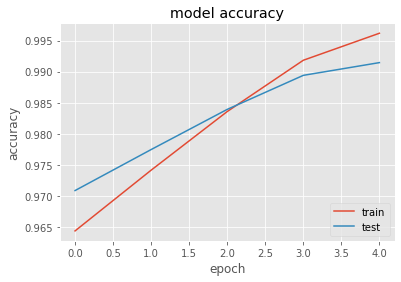

In [29]:
plt.plot(lstm_training.history['accuracy'])
plt.plot(lstm_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [30]:
lstm_model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model/assets


In [31]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

47/47 [==============================] - 2s 36ms/step - loss: 0.0315 - accuracy: 0.9910
Loss: 0.03149956092238426,
Accuracy: 0.9909636974334717
